If you want to run this notebook yourself, make sure to install [IJulia](https://github.com/JuliaLang/IJulia.jl) and [PyPlot](https://github.com/JuliaPy/PyPlot.jl) along with Korg. You can find the files you'll need [here](https://github.com/ajwheeler/Korg.jl/tree/main/misc/Tutorial%20notebooks).  Make sure you are using Julia 1.7 or greater, or you won't get the most recent version of Korg when you `Pkg.add` it.

**This notebook works for Korg versions of 0.22.0 and later.**

When you import with "using", a few functions are imported directly into the namespace (`synthesize`, `read_linelist`, `read_model_atmosphere`, `interpolate_marcs`, `format_A_X`).  All other need to be accessed with the `Korg` prefix, e.g. `Korg.air_to_vacuum`.

In [1]:
using Korg, PyPlot

Precompiling Korg
  ✓ Korg
  1 dependency successfully precompiled in 18 seconds. 122 already precompiled.


This notebook explains the basics of how to use Korg, but you can also see more detailed documentation for any function on the [documentation website](https://ajwheeler.github.io/Korg.jl/stable/API/), or by using Jupyter's built-in documentation viewer.  Uncomment the following cell to view detailed documentation for the synthesize function.

In [2]:
#?synthesize

## Choose a linelist

First, load a linelist.  The [`read_linelist`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.read_linelist) function, which is automatically exported when you do `using Korg` loads a linelist file (VALD, Kurucz, and MOOG formats accepted), and returns a vector of `Korg.Line` objects.

If you don't have a linelist you want to use, Korg comes with a VALD extract-stellar linelist for the sun that you can use to get started, as well as the APOGEE DR17 and GALAH DR3 linelists.

In [3]:
#lines = Korg.read_linelist("linelist.vald", format="vald")
lines = Korg.get_VALD_solar_linelist() # lines for the Sun from 3000 to 9000 Å
#lines = Korg.get_APOGEE_DR17_linelist() # if you want to do something in the infrared (this is for 15,000 Å - 17,000 Å)
#lines = Korg.get_GALAH_DR3_linelist()

41821-element Vector{Korg.Line{Float64, Float64, Float64, Float64, Float64, Float64}}:
 Fe I 3000.0414 Å (log gf = -2.96)
 Fe I 3000.0639 Å (log gf = -0.96)
 V I 3000.1011 Å (log gf = -0.48)
 Cr II 3000.1718 Å (log gf = -1.49)
 Fe I 3000.198 Å (log gf = -3.06)
 Ta II 3000.2515 Å (log gf = 0.7)
 Fe I 3000.2891 Å (log gf = -2.81)
 Ce II 3000.3084 Å (log gf = -1.25)
 Fe I 3000.3177 Å (log gf = -3.99)
 Ce II 3000.3556 Å (log gf = -0.96)
 Fe I 3000.3859 Å (log gf = -0.6)
 Re I 3000.4706 Å (log gf = 0.84)
 Ca I 3000.5197 Å (log gf = -0.98)
 ⋮
 Ti II 8981.6578 Å (log gf = -1.98)
 Ni I 8984.7962 Å (log gf = -2.56)
 Fe I 8986.4861 Å (log gf = -2.3)
 Fe I 8987.3527 Å (log gf = -0.92)
 Fe I 8989.6036 Å (log gf = -2.27)
 Mg I 8991.4958 Å (log gf = -2.47)
 Ti I 8991.9147 Å (log gf = -1.56)
 Fe II 8992.8729 Å (log gf = -2.5)
 Mg I 8994.1606 Å (log gf = -2.0)
 Si I 8995.8143 Å (log gf = -2.08)
 Fe I 8997.0972 Å (log gf = -3.19)
 Mg I 8999.623 Å (log gf = -1.77)

# Create a model atmosphere (via interpolation), or read one in from a file.

Korg can interpolate model atmospheres from the [grid of MARCS atmospheres generated for the Sloan Digital Sky Survey](https://www.sdss4.org/dr17/irspec/apogee-libraries/). 
To do this, use the `interpolate_marcs` function ([documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.interpolate_marcs)).  It takes 5 arguments: $T_\mathrm{eff}$, $\log g$, \[Fe/H\], \[$\alpha$/Fe\], and \[C/Fe\], but only  $T_\mathrm{eff}$ and $\log g$ are required.

**Important:** in general, you want the abundances of the model atmosphere to match those of the synthesis.  Below, I demonstrate how to do this easilly.

In [4]:
# this generates a model atmosphere for a dwarf with Teff = 5221 K and logg=4.32
dwarf_atm = Korg.interpolate_marcs(5221, 4.32) # we could also provide abundance parameters for non-solar values

Korg.PlanarAtmosphere{Float64, Float64, Float64, Float64, Float64} with 56 layers

Reading in a MARCS-format model atmosphere from a file is as simple as calling the `read_model_atmosphere` function.

In [5]:
#giant_atm = Korg.read_model_atmosphere("s6000_g+1.0_m0.5_t05_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod")

# Synthesizing a spectrum

Now we can synthesize a stellar spectrum, by passing the linelist and atmosphere to `synthesize` function, along with upper and lower wavelengths (in Å). Korg uses wavelengths *in vacuo*, but you can use [`Korg.air_to_vacuum`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.air_to_vacuum) and [`Korg.vacuum_to_air`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.vacuum_to_air) to convert back and forth. `synthesize` will also do this conversion automatically if you ask it to. See [the documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.synthesize) for a complete list of optional arguments.
`format_A_X()` returns the solar abundance pattern in the required format.

Julia is just-in-time compiled, which means that the first time in each session you call a method (e.g. `synthesize`, `read_linelist`, or `read_model_atmosphere`), the code will be compiled, which can take several seconds.  Here, we're using the `@time` macro to see how long each call to `synthesize` takes. The first one kinda slow, with lots of time devoted to compilation. When we call it a second time, it's much faster, because no code needs to be compiled. Note that no data is being cached an re-used here.  The wavelength range and model atmosphere are different.

In [6]:
# the semicolon supresses the output, so the notebook doesn't print everything returned by synthesize
@time synthesize(dwarf_atm, lines, format_A_X(0), 4000, 4030); 
# run this cell again to see how much faster it is after precompilation.

  8.390080 seconds (36.83 M allocations: 2.492 GiB, 7.58% gc time, 97.98% compilation time)


In [7]:
@time sol = synthesize(dwarf_atm, lines, format_A_X(0), 5000, 5030); 
# run this cell again to see how much faster it is after precompilation.

  0.158186 seconds (708.74 k allocations: 143.186 MiB, 21.83% gc time)


`synthesize` returns a named tuple containing the spectrum and other useful quantities.

In [8]:
keys(sol)

(:flux, :cntm, :intensity, :alpha, :number_densities, :electron_number_density, :wavelengths, :subspectra)

`flux`, `cntm`, and `wavelengths` are exactly what they sound like, and can be accessed like this:

In [9]:
sol.flux
#sol.wavelengths
#sol.cntm

3001-element Vector{Float64}:
 6.245155711699899e14
 6.245742561415436e14
 6.244405358674475e14
 6.244429027995492e14
 6.244485460135989e14
 6.243766918846148e14
 6.242533471637894e14
 6.235120334622648e14
 6.213751414860385e14
 6.16471605960851e14
 6.0818874045085e14
 5.986106906975035e14
 5.925188025796556e14
 ⋮
 6.234086493063782e14
 6.242872028731079e14
 6.245999910889416e14
 6.247846570905749e14
 6.249329588975568e14
 6.25061147049616e14
 6.251933366332071e14
 6.252915867335866e14
 6.253810689933321e14
 6.25462991748561e14
 6.255383371174378e14
 6.25607913550984e14

We can plot them with PyPlot like this:

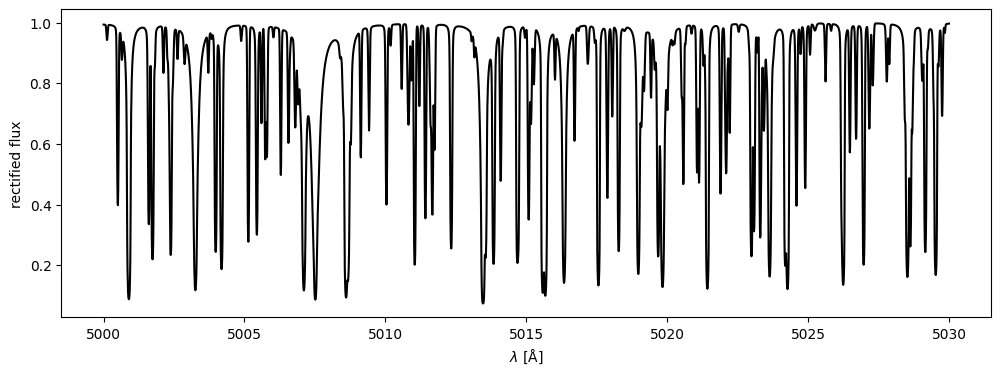

In [10]:
figure(figsize=(12, 4))
plot(sol.wavelengths, sol.flux ./ sol.cntm, "k-") # "./" is how you do element-wise division in Julia
xlabel(L"$\lambda$ [Å]")
ylabel("rectified flux");

## Specifying abundances

Let's synthesize spectra with varied abundances and take a look at the results.
Korg takes in a vector of abundances for all elements from H to U in $A(X)$ format. The `format_A_X` function provies an easy way to do this. The first argument specifies the default `[X/H]` abundance, the second lets you specify the default `[alpha/H]` abundance, and the third lets you specify individual abundances.


In [11]:
metal_poor_A_X = format_A_X(-0.5) # [M/H] = -1/2
alpha_rich_A_X = format_A_X(0, 0.5) # all [M/H] = 0, but [alpha/H] = 0.5]
Ni_enriched_A_X = format_A_X(Dict("Ni"=>1.0)) # all [M/H] = 0, except [Ni/H] = 1.0
;

In order to make sure that the model atmosphere abundances match the synthesis abundances, we pass `A_X` vectors directly to `interpolate_marcs`.

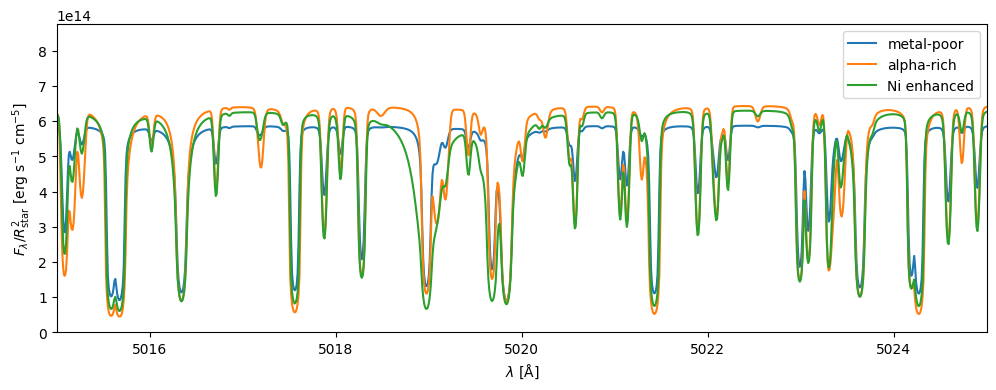

In [12]:
metal_poor_atm = interpolate_marcs(5221, 4.32, metal_poor_A_X)
metal_poor_sol = synthesize(metal_poor_atm, lines, metal_poor_A_X, 5015, 5025)

alpha_rich_sol = interpolate_marcs(5221, 4.32, alpha_rich_A_X)
alpha_rich_sol = synthesize(alpha_rich_sol, lines, alpha_rich_A_X, 5015, 5025)

Ni_enriched_atm = interpolate_marcs(5221, 4.32, Ni_enriched_A_X)
Ni_enriched_sol = synthesize(Ni_enriched_atm, lines, Ni_enriched_A_X, 5015, 5025)

figure(figsize=(12, 4))
plot(metal_poor_sol.wavelengths, metal_poor_sol.flux, label="metal-poor")
plot(alpha_rich_sol.wavelengths, alpha_rich_sol.flux, label="alpha-rich")
plot(Ni_enriched_sol.wavelengths, Ni_enriched_sol.flux, label="Ni enhanced")

xlabel(L"$\lambda$ [Å]")
ylabel(L"$F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]")
xlim(5015, 5025)
ylim(0, ylim()[2]*1.3) # make a little room on top for the legend
legend();

## Other data returned by `synthesize`

`sol.alpha` is a matrix containing the absorption coefficient, $\alpha$ at each wavelength and atmospheric layer.  We can plot $\alpha$ as a function of wavelength like this.

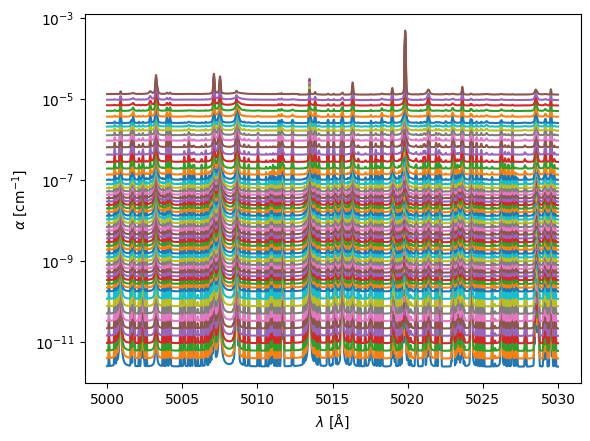

In [13]:
plot(sol.wavelengths, sol.alpha'); # sol.alpha' is the adjoint of sol.alpha.
yscale("log")
xlabel(L"$\lambda$ [Å]")
ylabel(L"$\alpha$ [cm$^{-1}$]");

Let's look at the last bit of info that synthesize returns.  `sol.number_densities` is a dictionary which maps Korg `Species` objects to their number densities in each layer of the atmosphere.

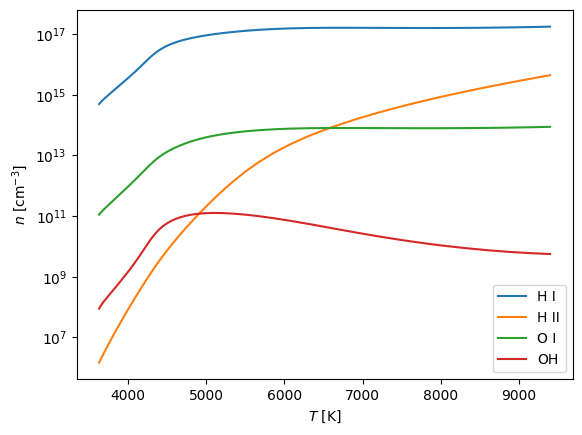

In [14]:
temps = Korg.get_temps(dwarf_atm)

# These strings represent different species. Below, we pass them to Korg.Species to construct a Species object.
for spec in ["H I", "H II", "O I", "OH"] 
    plot(temps, sol.number_densities[Korg.Species(spec)], label=spec)
end

legend()
yscale("log")
xlabel(L"$T$ [K]")
ylabel(L"$n$ [cm$^{-3}$]");